##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
%pip install -Uq "google-genai==1.7.0"

ERROR: You must give at least one requirement to install (see "pip help install")

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Use the API

In [2]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

In [35]:
import os

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)
MODEL_ID = 'gemini-2.5-flash-preview-04-17'

In [19]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
    genai.models.Models.generate_content = retry.Retry(predicate=is_retriable)(genai.models.Models.generate_content)

In [20]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="When and where is Billie Eilish's next concert?"
)

In [21]:
Markdown(response.text)

As of right now, Billie Eilish has not officially announced specific dates and locations for her next major tour.

She is currently working on her upcoming third studio album. New tour dates are typically announced closer to or after an album release.

To get the most up-to-date information on her future concerts, the best resources are:

1.  **Billie Eilish's Official Website:** Keep an eye on the "Tour" or "Dates" section.
2.  **Her Official Social Media Channels:** Announcements are often made there first.
3.  **Major Ticketing Websites:** Sites like Ticketmaster, Live Nation, or AXS will list dates once they are confirmed and tickets go on sale.

Check these sources regularly for updates!

In [22]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())]
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="When and where is Billie Eilish's next concert?",
    config=config_with_search
)

Markdown(response.candidates[0].content.parts[0].text)

Billie Eilish has several upcoming concert dates as part of her "Hit Me Hard and Soft: The Tour". According to the search results, her next concert is scheduled for April 23, 2025, at the Avicii Arena in Stockholm, Sweden. She has another concert at the same venue on April 24, 2025.

Following the dates in Stockholm, she will be playing in various locations across Europe and the UK in April, May, June, and July of 2025, and then in Australia in February and March 2025. There are also North American dates listed for late 2024.

To find the most up-to-date and complete list of concert dates and locations, it's recommended to check official ticketing websites like Ticketmaster, Live Nation, or StubHub, or Billie Eilish's official website.

## Response Meta

In [23]:
while not response.candidates[0].grounding_metadata.grounding_supports or not response.candidates[0].grounding_metadata.grounding_chunks:
    response = client.models.generate_content(
    model=MODEL_ID,
    contents="When and where is Billie Eilish's next concert?",
    config=config_with_search
    )

chunks = response.candidates[0].grounding_metadata.grounding_chunks

for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')




ticketmaster.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIqwi0F7kL78K1QZKKCR12hC10MPR2Q_TSF32mjTEWMzEYMaBW8i1p3b_5O0pHNK5-DYVz9BzGj3kYlgy29J5HU-pJBS-F_U5mniiUvrBuSCx0cEbd3XVbny2AEu-m8Ui0kDTW0yBbloRf0NNh2Ivb0BYzNMlWrnw==
ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKoR3Afa9W1-1A19pZFPpCQOuLTKgjIyUZIowoDavfh_cOmAV92Of7G1yXVtB5zQpXXuEwg0wh0Nov3h3Id1eSFtNsr0S9ZrAfPHdL7DNpW0ILwnHirLzQKUNN-rRSiW5PYHLhHxXzalQbodeBxcAGvAyXU5Q1Gw_yw


In [24]:
HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content)

In [25]:
from pprint import pprint

supports = response.candidates[0].grounding_metadata.grounding_supports


In [26]:
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.6128539],
 'grounding_chunk_indices': [0],
 'segment': {'end_index': 222,
             'start_index': 98,
             'text': 'According to the search results, her next concert is '
                     'scheduled for April 23, 2025, at the Avicii Arena in '
                     'Stockholm, Sweden.'}}
{'confidence_scores': [0.6173069],
 'grounding_chunk_indices': [1],
 'segment': {'end_index': 473,
             'start_index': 285,
             'text': 'Following the dates in Stockholm, she will be playing in '
                     'various locations across Europe and the UK in April, '
                     'May, June, and July of 2025, and then in Australia in '
                     'February and March 2025.'}}
{'confidence_scores': [0.67730105, 0.7174366],
 'grounding_chunk_indices': [1, 0],
 'segment': {'end_index': 531,
             'start_index': 474,
             'text': 'There are also North American dates listed for late '
                     '2024.'}}

In [27]:
import io

markdown_buffer = io.StringIO()

markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        response.candidates[0].content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")

markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


In [28]:
Markdown(markdown_buffer.getvalue())

Supported text:

 * According to the search results, her next concert is scheduled for April 23, 2025, at the Avicii Arena in Stockholm, Sweden.<sup>[1]</sup>

 * Following the dates in Stockholm, she will be playing in various locations across Europe and the UK in April, May, June, and July of 2025, and then in Australia in February and March 2025.<sup>[2]</sup>

 * There are also North American dates listed for late 2024.<sup>[2]</sup><sup>[1]</sup>

Citations:

1. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIqwi0F7kL78K1QZKKCR12hC10MPR2Q_TSF32mjTEWMzEYMaBW8i1p3b_5O0pHNK5-DYVz9BzGj3kYlgy29J5HU-pJBS-F_U5mniiUvrBuSCx0cEbd3XVbny2AEu-m8Ui0kDTW0yBbloRf0NNh2Ivb0BYzNMlWrnw==)
2. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKoR3Afa9W1-1A19pZFPpCQOuLTKgjIyUZIowoDavfh_cOmAV92Of7G1yXVtB5zQpXXuEwg0wh0Nov3h3Id1eSFtNsr0S9ZrAfPHdL7DNpW0ILwnHirLzQKUNN-rRSiW5PYHLhHxXzalQbodeBxcAGvAyXU5Q1Gw_yw)


## Search with tools

In [29]:
from IPython.display import display, Image, Markdown, Code, HTML

# def show_response(response):
#     for p in response.candidates[0].content.parts:
#         if p.text:
#             display(Markdown(p.text))
#         elif p.inline_data:
#             display(Image(p.inline_data.data))
#         elif p.executable_code:
#             display(Markdown(f"```\n{p.executable_code.code}\n```"))
#         else:
#             print(p.to_json_dict())
        
    
#         display(Markdown('----'))

def show_response(response):
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      display(Markdown(part.text))
    if part.executable_code is not None:
      code_html = f'<pre style="background-color: green;">{part.executable_code.code}</pre>' # Change code color
      display(HTML(code_html))
    if part.code_execution_result is not None:
      display(Markdown(part.code_execution_result.output))
    if part.inline_data is not None:
      display(Image(data=part.inline_data.data, width=800, format="png"))
    display(Markdown("---"))

In [36]:
config_with_search = types.GenerateContentConfig(
    # tools=[types.Tool(google_search=types.GoogleSearch())],
    tools=[
        {'google_search': {}}
    ],
    temperature=0.0,
)

chat = client.chats.create(model=MODEL_ID)

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

The 2024 Summer Olympics in Paris have concluded as of August 11, 2024. Here are the top 10 countries based on their total medal count:

| Country        | Gold | Silver | Bronze | Total |
|----------------|------|--------|--------|-------|
| USA            | 40   | 44     | 42     | 126   |
| China          | 40   | 27     | 24     | 91    |
| Great Britain  | 14   | 22     | 29     | 65    |
| France         | 16   | 25     | 23     | 64    |
| Australia      | 18   | 19     | 16     | 53    |
| Italy          | 12   | 15     | 13     | 40    |
| Germany        | 12   | 13     | 8      | 33    |
| Netherlands    | 15   | 7      | 12     | 34    |
| Japan          | 20   | 12     | 13     | 45    |
| South Korea    | 13   | 9      | 10     | 32    |

Please note that some sources may order the table by gold medals first, which would change the ranking order for some countries with the same total number of medals. The table above is ordered by the total number of medals.

---

Okay, I can plot the medal tallies for the top 10 countries from the 2024 Paris Olympics, broken down by medal type (Gold, Silver, Bronze), using seaborn and matplotlib.

First, I will prepare the data in a format suitable for plotting. Then, I will generate the stacked bar chart, save it as an image file, and display the image.



---

---

No module named 'IPython'
Traceback (most recent call last):
  File "/usr/bin/entry/entry_point", line 117, in _run_python
    exec(code, exec_scope)  # pylint: disable=exec-used
    ^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 6, in <module>
ModuleNotFoundError: No module named 'IPython'


---

Okay, it seems I cannot directly display the image using the available tools. However, I can save the plot to a file.

I will generate the plot and save it as `olympics_2024_medals.png`.



---

---

Plot saved successfully as olympics_2024_medals.png


---

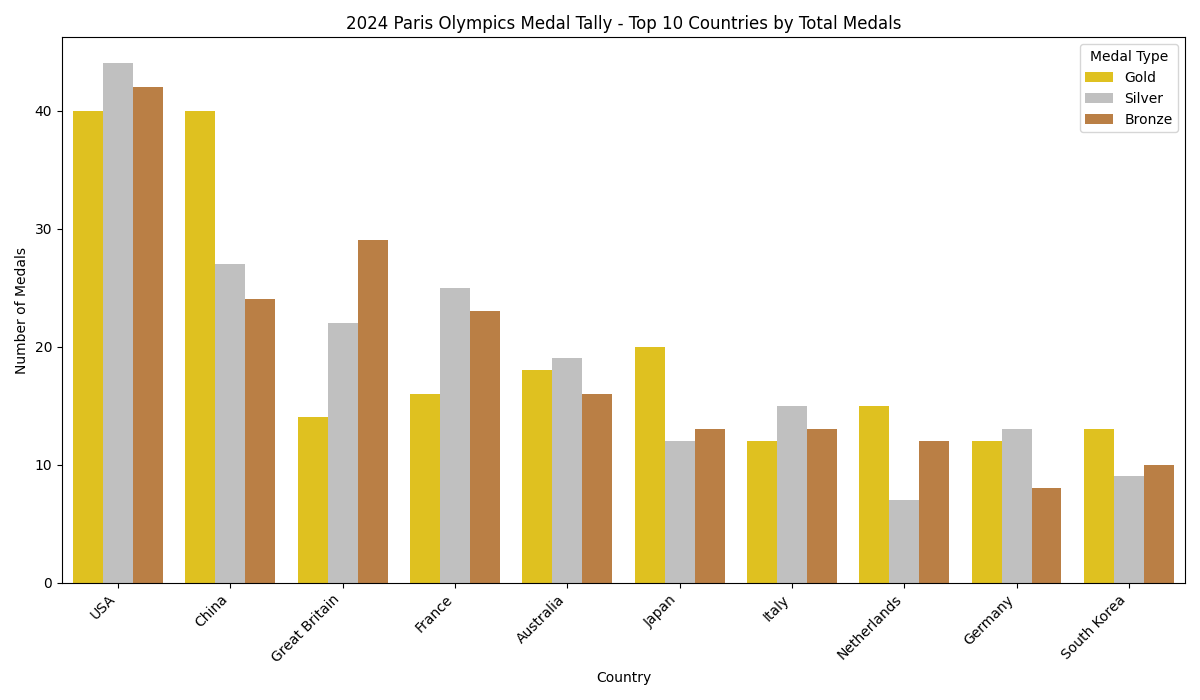

---

I have generated the stacked bar chart showing the breakdown of Gold, Silver, and Bronze medals for the top 10 countries by total medal count at the 2024 Paris Olympics.

The plot has been saved as `olympics_2024_medals.png`. You should be able to view this file.

---

In [37]:
config_with_code = types.GenerateContentConfig(
    # tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    tools = [{'code_execution': {}}],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too. Then save the plot as an image file and display the image.",
    config=config_with_code,
)

show_response(response)